In [270]:
import numpy as np
import math
from math import sin, cos, tan
from numpy import matmul as mm  # Matrix multiplication
from numpy import linalg as lg
import matplotlib.pyplot as plt

print('----- Import Finished -----')


----- Import Finished -----


In [271]:
# def sin(o):
#     return math.sin(o)

# def cos(o):
#     return math.cos(o)

# def tan(o):
#     return math.tan(o)


class laminate():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 250e9  # Young Modulus of fibers
        self.E2f = 15e9  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.2 # Poisson's ratio of fibers
        self.G12f = 14e9 # Shear Modulus of fibers

        self.Em = 12e9      # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = (self.V12 * self.E22) / self.E11                                 # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 3                                     # number of plys
        self.thickness = 22.8e-3 / 2                          # Thickness of the composite
        # self.ply_angle = [0, 90]                       # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix


    def plys(self, th1, th2, th3):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = [th1, th2, th3]

        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_ABD(self, th1, th2, th3):

        laminate.plys(self,  th1 = th1, th2 = th2, th3 = th3)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0
        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return A, B, D, ABD, ABD_inv


    def Result_print(self, th1, th2, th3):
    
        A, B, D, ABD, ABD_inv = laminate.cal_ABD(self, th1 = th1, th2 = th2, th3 = th3)

        # # Printing the A, B and D matrices
        # print("\n[A] matrix:")
        # print('[' + format(A[0][0], '^12.2e') + format(A[0][1], '^12.2e') + format(A[0][2], '^12.2e') + ']')
        # print('[' + format(A[1][0], '^12.2e') + format(A[1][1], '^12.2e') + format(A[1][2], '^12.2e') + ']')
        # print('[' + format(A[2][0], '^12.2e') + format(A[2][1], '^12.2e') + format(A[2][2], '^12.2e') + ']')
        # print("\n[B] matrix:")
        # print('[' + format(B[0][0], '^12.2e') + format(B[0][1], '^12.2e') + format(B[0][2], '^12.2e') + ']')
        # print('[' + format(B[1][0], '^12.2e') + format(B[1][1], '^12.2e') + format(B[1][2], '^12.2e') + ']')
        # print('[' + format(B[2][0], '^12.2e') + format(B[2][1], '^12.2e') + format(B[2][2], '^12.2e') + ']')
        # print("\n[D] matrix:")
        # print('[' + format(D[0][0], '^12.2e') + format(D[0][1], '^12.2e') + format(D[0][2], '^12.2e') + ']')
        # print('[' + format(D[1][0], '^12.2e') + format(D[1][1], '^12.2e') + format(D[1][2], '^12.2e') + ']')
        # print('[' + format(D[2][0], '^12.2e') + format(D[2][1], '^12.2e') + format(D[2][2], '^12.2e') + ']')

        # Printing the [ABD] matrix
        print("\n[ABD] matrix:")
        print('[' + format(ABD[0][0], '^12.2e') + format(ABD[0][1], '^12.2e') + format(ABD[0][2], '^12.2e') + format(ABD[0][3], '^12.2e') + format(ABD[0][4], '^12.2e') + format(ABD[0][5], '^12.2e') + ']')
        print('[' + format(ABD[1][0], '^12.2e') + format(ABD[1][1], '^12.2e') + format(ABD[1][2], '^12.2e') + format(ABD[1][3], '^12.2e') + format(ABD[1][4], '^12.2e') + format(ABD[1][5], '^12.2e') + ']')
        print('[' + format(ABD[2][0], '^12.2e') + format(ABD[2][1], '^12.2e') + format(ABD[2][2], '^12.2e') + format(ABD[2][3], '^12.2e') + format(ABD[2][4], '^12.2e') + format(ABD[2][5], '^12.2e') + ']')
        print('[' + format(ABD[3][0], '^12.2e') + format(ABD[3][1], '^12.2e') + format(ABD[3][2], '^12.2e') + format(ABD[3][3], '^12.2e') + format(ABD[3][4], '^12.2e') + format(ABD[3][5], '^12.2e') + ']')
        print('[' + format(ABD[4][0], '^12.2e') + format(ABD[4][1], '^12.2e') + format(ABD[4][2], '^12.2e') + format(ABD[4][3], '^12.2e') + format(ABD[4][4], '^12.2e') + format(ABD[4][5], '^12.2e') + ']')
        print('[' + format(ABD[5][0], '^12.2e') + format(ABD[5][1], '^12.2e') + format(ABD[5][2], '^12.2e') + format(ABD[5][3], '^12.2e') + format(ABD[5][4], '^12.2e') + format(ABD[5][5], '^12.2e') + ']')


        # Printing the inverse [ABD] matrix
        print("\n[ABD]\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE} matrix")
        print('[' + format(ABD_inv[0][0], '^12.2e') + format(ABD_inv[0][1], '^12.2e') + format(ABD_inv[0][2], '^12.2e') + format(ABD_inv[0][3], '^12.2e') + format(ABD_inv[0][4], '^12.2e') + format(ABD_inv[0][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[1][0], '^12.2e') + format(ABD_inv[1][1], '^12.2e') + format(ABD_inv[1][2], '^12.2e') + format(ABD_inv[1][3], '^12.2e') + format(ABD_inv[1][4], '^12.2e') + format(ABD_inv[1][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[2][0], '^12.2e') + format(ABD_inv[2][1], '^12.2e') + format(ABD_inv[2][2], '^12.2e') + format(ABD_inv[2][3], '^12.2e') + format(ABD_inv[2][4], '^12.2e') + format(ABD_inv[2][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[3][0], '^12.2e') + format(ABD_inv[3][1], '^12.2e') + format(ABD_inv[3][2], '^12.2e') + format(ABD_inv[3][3], '^12.2e') + format(ABD_inv[3][4], '^12.2e') + format(ABD_inv[3][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[4][0], '^12.2e') + format(ABD_inv[4][1], '^12.2e') + format(ABD_inv[4][2], '^12.2e') + format(ABD_inv[4][3], '^12.2e') + format(ABD_inv[4][4], '^12.2e') + format(ABD_inv[4][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[5][0], '^12.2e') + format(ABD_inv[5][1], '^12.2e') + format(ABD_inv[5][2], '^12.2e') + format(ABD_inv[5][3], '^12.2e') + format(ABD_inv[5][4], '^12.2e') + format(ABD_inv[5][5], '^12.2e') + ']')




A, B, D, ABD, ABD_inv = laminate().cal_ABD(th1 = 0, th2 = 0, th3 = 0)
# print('ABD: \n', ABD)
# print('ABD_inv: \n', ABD_inv)


In [272]:
# def sin(o):
#     return math.sin(o)

# def cos(o):
#     return math.cos(o)

# def tan(o):
#     return math.tan(o)


class laminate_Gpa():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 250  # Young Modulus of fibers
        self.E2f = 15  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.2 # Poisson's ratio of fibers
        self.G12f = 14 # Shear Modulus of fibers

        self.Em = 12      # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = (self.V12 * self.E22) / self.E11                                 # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 3                                     # number of plys
        self.thickness = 22.8e-3 / 2                          # Thickness of the composite
        # self.ply_angle = [0, 90]                       # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix


    def plys(self, th1, th2, th3):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = [th1, th2, th3]

        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_ABD(self, th1, th2, th3):

        laminate.plys(self,  th1 = th1, th2 = th2, th3 = th3)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0
        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return A, B, D, ABD, ABD_inv


    def Result_print(self, th1, th2, th3):
    
        A, B, D, ABD, ABD_inv = laminate.cal_ABD(self, th1 = th1, th2 = th2, th3 = th3)

        # # Printing the A, B and D matrices
        # print("\n[A] matrix:")
        # print('[' + format(A[0][0], '^12.2e') + format(A[0][1], '^12.2e') + format(A[0][2], '^12.2e') + ']')
        # print('[' + format(A[1][0], '^12.2e') + format(A[1][1], '^12.2e') + format(A[1][2], '^12.2e') + ']')
        # print('[' + format(A[2][0], '^12.2e') + format(A[2][1], '^12.2e') + format(A[2][2], '^12.2e') + ']')
        # print("\n[B] matrix:")
        # print('[' + format(B[0][0], '^12.2e') + format(B[0][1], '^12.2e') + format(B[0][2], '^12.2e') + ']')
        # print('[' + format(B[1][0], '^12.2e') + format(B[1][1], '^12.2e') + format(B[1][2], '^12.2e') + ']')
        # print('[' + format(B[2][0], '^12.2e') + format(B[2][1], '^12.2e') + format(B[2][2], '^12.2e') + ']')
        # print("\n[D] matrix:")
        # print('[' + format(D[0][0], '^12.2e') + format(D[0][1], '^12.2e') + format(D[0][2], '^12.2e') + ']')
        # print('[' + format(D[1][0], '^12.2e') + format(D[1][1], '^12.2e') + format(D[1][2], '^12.2e') + ']')
        # print('[' + format(D[2][0], '^12.2e') + format(D[2][1], '^12.2e') + format(D[2][2], '^12.2e') + ']')

        # Printing the [ABD] matrix
        print("\n[ABD] matrix:")
        print('[' + format(ABD[0][0], '^12.2e') + format(ABD[0][1], '^12.2e') + format(ABD[0][2], '^12.2e') + format(ABD[0][3], '^12.2e') + format(ABD[0][4], '^12.2e') + format(ABD[0][5], '^12.2e') + ']')
        print('[' + format(ABD[1][0], '^12.2e') + format(ABD[1][1], '^12.2e') + format(ABD[1][2], '^12.2e') + format(ABD[1][3], '^12.2e') + format(ABD[1][4], '^12.2e') + format(ABD[1][5], '^12.2e') + ']')
        print('[' + format(ABD[2][0], '^12.2e') + format(ABD[2][1], '^12.2e') + format(ABD[2][2], '^12.2e') + format(ABD[2][3], '^12.2e') + format(ABD[2][4], '^12.2e') + format(ABD[2][5], '^12.2e') + ']')
        print('[' + format(ABD[3][0], '^12.2e') + format(ABD[3][1], '^12.2e') + format(ABD[3][2], '^12.2e') + format(ABD[3][3], '^12.2e') + format(ABD[3][4], '^12.2e') + format(ABD[3][5], '^12.2e') + ']')
        print('[' + format(ABD[4][0], '^12.2e') + format(ABD[4][1], '^12.2e') + format(ABD[4][2], '^12.2e') + format(ABD[4][3], '^12.2e') + format(ABD[4][4], '^12.2e') + format(ABD[4][5], '^12.2e') + ']')
        print('[' + format(ABD[5][0], '^12.2e') + format(ABD[5][1], '^12.2e') + format(ABD[5][2], '^12.2e') + format(ABD[5][3], '^12.2e') + format(ABD[5][4], '^12.2e') + format(ABD[5][5], '^12.2e') + ']')


        # Printing the inverse [ABD] matrix
        print("\n[ABD]\N{SUPERSCRIPT MINUS}\N{SUPERSCRIPT ONE} matrix")
        print('[' + format(ABD_inv[0][0], '^12.2e') + format(ABD_inv[0][1], '^12.2e') + format(ABD_inv[0][2], '^12.2e') + format(ABD_inv[0][3], '^12.2e') + format(ABD_inv[0][4], '^12.2e') + format(ABD_inv[0][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[1][0], '^12.2e') + format(ABD_inv[1][1], '^12.2e') + format(ABD_inv[1][2], '^12.2e') + format(ABD_inv[1][3], '^12.2e') + format(ABD_inv[1][4], '^12.2e') + format(ABD_inv[1][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[2][0], '^12.2e') + format(ABD_inv[2][1], '^12.2e') + format(ABD_inv[2][2], '^12.2e') + format(ABD_inv[2][3], '^12.2e') + format(ABD_inv[2][4], '^12.2e') + format(ABD_inv[2][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[3][0], '^12.2e') + format(ABD_inv[3][1], '^12.2e') + format(ABD_inv[3][2], '^12.2e') + format(ABD_inv[3][3], '^12.2e') + format(ABD_inv[3][4], '^12.2e') + format(ABD_inv[3][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[4][0], '^12.2e') + format(ABD_inv[4][1], '^12.2e') + format(ABD_inv[4][2], '^12.2e') + format(ABD_inv[4][3], '^12.2e') + format(ABD_inv[4][4], '^12.2e') + format(ABD_inv[4][5], '^12.2e') + ']')
        print('[' + format(ABD_inv[5][0], '^12.2e') + format(ABD_inv[5][1], '^12.2e') + format(ABD_inv[5][2], '^12.2e') + format(ABD_inv[5][3], '^12.2e') + format(ABD_inv[5][4], '^12.2e') + format(ABD_inv[5][5], '^12.2e') + ']')




A, B, D, ABD, ABD_inv = laminate_Gpa().cal_ABD(th1 = 0, th2 = 0, th3 = 0)
# print('ABD: \n', ABD)
# print('ABD_inv: \n', ABD_inv)


# Question 4-a

In [273]:
laminate().Result_print(th1 = 0, th2 = 0, th3 = 0)


[ABD] matrix:
[  1.50e+09    3.69e+07    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  3.69e+07    1.54e+08    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    8.89e+07    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    1.63e+04    4.00e+02    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    4.00e+02    1.67e+03    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    9.63e+02  ]

[ABD]⁻¹ matrix
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    6.54e-09    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    1.12e-08    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    6.18e-05   -1.48e-05    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00   -1.48e-05    6.04e-04    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    1.04e-03  ]


In [274]:
laminate_Gpa().Result_print(th1=0, th2=0, th3=0)



[ABD] matrix:
[  1.50e+00    3.69e-02    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  3.69e-02    1.54e-01    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    8.89e-02    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    1.63e-05    4.00e-07    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    4.00e-07    1.67e-06    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    9.63e-07  ]

[ABD]⁻¹ matrix
[  6.70e-01   -1.61e-01    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[ -1.61e-01    6.54e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    1.12e+01    0.00e+00    0.00e+00    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    6.18e+04   -1.48e+04    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00   -1.48e+04    6.04e+05    0.00e+00  ]
[  0.00e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00    1.04e+06  ]


In [275]:
def threeinone():
    Load_known = [0, 0, 0, 10000, 0, 10000]
    angle = []
    Deformation = []
    Dimension = []
    for th1 in range(0, 30):
        for th2 in range(0, 30):
            for th3 in range(0, 30):
                A, B, D, ABD, ABD_inv = laminate().cal_ABD(th1=th1, th2=th2, th3=th3)
                #print(mm(ABD_inv, load))
                #ABD_inv = ABD_inv.tolist().clear()
                Deformation.append(mm(ABD_inv, Load_known))
                angle.append([th1, th2, th3])


    Deformation = np.array(Deformation)
    angle = np.array(angle)
    print(Deformation.shape)
    print(angle.shape)
    return Deformation, angle
Deformation, angle = threeinone()

(27000, 6)
(27000, 3)


In [276]:
def kminmax(Deformation):
    
    QQQ = np.array(Deformation[:, 3])  # Kxx
    
    if abs(min(Deformation[:, 3])) < abs(max(Deformation[:, 3])):  # Kxxmax
        print('kxxmax1 =', max(Deformation[:, 3]))
        angle_max = np.where(QQQ == np.max(QQQ))
        print('The angle of kxxmax:')
        print('Theta1, Theta2, Theta3:', angle[angle_max])

    else:
        print('kxxmax2 =', -min(Deformation[:, 3]))
        angle_max = np.where(QQQ == np.min(QQQ))
        print('The angle of kxxmax:')
        print('Theta1, Theta2, Theta3:', angle[angle_max])

    #if 10e-8 <= min(Deformation[:, 3]) + min(Deformation[:, 3]) <= -10e-8:
    if min(Deformation[:, 3]) >= 0:  # Kxxmin
        print('kxxmin1 =', min(Deformation[:, 3]))
        angle_min = np.where(QQQ == np.min(QQQ))
        print('The angle of kxxmin:')
        print('Theta1, Theta2, Theta3:', angle[angle_min])

    else:
        print('kxxmin2 =', abs(min(map(abs, Deformation[:, 3]))))
        angle_min = np.where(QQQ == -min(map(abs, Deformation[:, 3])))
        print('The angle of kxxmin:')
        print('Theta1, Theta2, Theta3:', angle[angle_min])

    SSS = np.array(Deformation[:, 5]) # Kxy

    if abs(min(Deformation[:, 5])) < abs(max(Deformation[:, 5])):
        print('kxymax1 =', max(Deformation[:, 5]))
        angle2_max = np.where(SSS == np.max(SSS))
        print('The angle of kxymax:')
        print('Theta1, Theta2, Theta3:', angle[angle2_max])
        
    else:
        print('kxymax2 =', -min(Deformation[:, 5]))
        angle2_max = np.where(SSS == np.min(SSS))
        print('The angle of kxymax:')
        print('Theta1, Theta2, Theta3:', angle[angle2_max])


    if min(Deformation[:, 5]) > 0:  # Kxymin
        print('kxymin1 =', min(Deformation[:, 5]))
        angle2_min = np.where(SSS == np.min(SSS))
        print('The angle of kxymin:')
        print('Theta1, Theta2, Theta3:', angle[angle2_min])
        
    else:
        print('kxymin2 =', abs(min(map(abs, Deformation[:, 5]))))
        angle2_min = np.where(SSS == -min(map(abs, Deformation[:, 5])))
        print('The angle of kxymin:')
        print('Theta1, Theta2, Theta3:', angle[angle2_min])

                


In [277]:
#print(Deformation)
kminmax(Deformation = Deformation)
print(min(Deformation[:, 5]))

kxxmax2 = 0.9831084557865004
The angle of kxxmax:
Theta1, Theta2, Theta3: [[19 19 19]]
kxxmin2 = 0.0005426291793609872
The angle of kxxmin:
Theta1, Theta2, Theta3: [[ 0 15  9]]
kxymax1 = 10.386067732038095
The angle of kxymax:
Theta1, Theta2, Theta3: [[0 0 0]]
kxymin1 = 4.772356138934702
The angle of kxymin:
Theta1, Theta2, Theta3: [[29  0 29]]
4.772356138934702


# Question 4-b

In [278]:

class Stress():
    def __init__(self):
        #super(self).__init__()
        # Bacis parameters of composite
        self.E1f = 250  # Young Modulus of fibers
        self.E2f = 15  # Young Modulus of fibers in 2 direction
        self.Rf = 0.5   # Fiber volume fraction
        self.V12f = 0.2 # Poisson's ratio of fibers
        self.G12f = 14 # Shear Modulus of fibers

        self.Em = 12      # Young Modulus of matrix
        self.Vm = 0.28   # Poisson's ratio of matrix
        self.Gm = self.Em / (2 + 2 * self.Vm)  # Shear Modulus of matrix

        self.etaE = (self.E2f - self.Em) / (self.E2f + self.Em)
        self.etaG = (self.G12f - self.Gm) / (self.G12f + self.Gm)



        # Local coordinate system
        self.E11 = self.Rf * self.E1f + (1 - self.Rf) * self.Em                     # Young Modulus in 1
        self.E22 = self.Em * (1 + self.etaE * self.Rf) / (1 - self.etaE * self.Rf)  # Young Modulus in 2
        self.V12 = self.Rf * self.V12f + (1 - self.Rf) * self.Vm                    # Poisson's ratio 21
        self.V21 = (self.V12 * self.E22) / self.E11                                 # Poisson's ratio 12, V21/E11 = V12/E22
        self.G12 = self.Gm * (1 + self.etaG * self.Rf) / (1 - self.etaG * self.Rf)  # Shear modulus of composite

        # parameters of composite
        self.N = 6                                     # number of plys
        self.thickness = 22.8e-3                          # Thickness of the composite
        # self.ply_angle = [0, 90]                       # angle of each plys
        self.angle = None                              # radian angle
        self.z = None                                  # ply

        # Matrix
        self.S = None          # positive axis compliance matrix
        self.Q = None          # positive-axis modulus matrix
        self.T_stress = None   # stress conversion matrix
        self.T_strain = None   # strain conversion matrix


    def plys(self, ply_angle):
        N = self.N             # number of plies
        t_ply = [self.thickness / self.N] * N  # ply thickness in m
        t_LAM = 0

        for i in range(N):
            t_LAM += t_ply[i]  # laminate thickness in m, 8 multiply by the thinkness of each ply

        # Distance from laminate mid-plane to out surfaces of plies in m
        z = self.z
        z = [0] * (N+1)
        for i in range(N+1):
            z[i] = (-t_LAM / 2) + (i * t_ply[i-1])
        #print(z[1])

        # Distance from laminate mid-plane to mid-planes of plies in m
        z_mid_plane = [0] * N
        for i in range(N):
            z_mid_plane[i] = (-t_LAM / 2) - (t_ply[i]/2) + ((i+1) * t_ply[i])

        # Enter a desired ply orientation angle in degrees here:
        ply_angle = ply_angle

        # Ply orientation angle translated to radians to simplify equations below
        angle = [0] * N
        for i in range(N):
            angle[i] = math.radians(ply_angle[i])

        # Stress Transformation (Global to Local), pg 112
        self.T_stress = [0] * N
        for i in range(N):
            self.T_stress[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, 2*sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
             -2*sin(angle[i])*cos(angle[i])], [-sin(angle[i])*cos(angle[i]), sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        # Strain Transformation (Global-to-Local), pg 113
        self.T_strain = [0] * N
        for i in range(N):
            self.T_strain[i] = np.array([[cos(angle[i])**2, sin(angle[i])**2, sin(angle[i])*cos(angle[i])], [sin(angle[i])**2, cos(angle[i])**2,
            -sin(angle[i])*cos(angle[i])], [-2*sin(angle[i])*cos(angle[i]), 2*sin(angle[i])*cos(angle[i]), cos(angle[i])**2-sin(angle[i])**2]])

        self.angle = angle
        self.t_ply = t_ply
        self.z = z

        # for i in range(8):
        #     print(self.T_stress[i])
        return self.T_stress, self.T_strain, self.angle, self.t_ply, self.z




    def cal_Q_global(self, ply_angle):

        Stress.plys(self, ply_angle=ply_angle)

        # Parameters of the composite
        E11 = self.E11
        E22 = self.E22
        V21 = self.V21
        V12 = self.V12
        G12 = self.G12

        N = self.N
        t_ply = self.t_ply
        T_stress = self.T_stress
        T_strain = self.T_strain
        z = self.z
        #print('z:', z)

        # The local/lamina compliance matrix
        S11 = 1/E11
        S12 = -V21/E22
        S21 = -V12/E11
        S22 = 1/E22
        S66 = 1/G12
        S16 = S61 = S26 = S62 = 0
        S = np.array([[S11, S12, 0], [S21, S22, 0], [0, 0, S66]])

        # The local/lamina stiffness matrix
        Q_loc = lg.inv(S)  # The inverse of the S matrix
        #print('Q_loc:', Q_loc)

        # The global/laminate stiffness and compliance matrices
        Q_glo = [0.0] * N
        for i in range(N):
            Q_glo[i] = mm(lg.inv(T_stress[i]), mm(Q_loc, T_strain[i]))
        #print('Q_glo；', Q_glo)

        # Calculate the ABD Matrix
        A = [[0.0]*3] * 3
        for i in range(N):
            A += Q_glo[i] * t_ply[i]

        B = [[0.0]*3] * 3
        for i in range(N):
            B += (1 / 2) * (Q_glo[i] * ((z[i + 1]**2) - ((z[i + 1] - t_ply[i])**2)))

        D = [[0.0]*3] * 3
        for i in range(N):
            D += (1/3) * (Q_glo[i] * ((z[i+1] ** 3) - ((z[i+1] - t_ply[i]) ** 3)))

        ABD = np.array([[A[0][0],A[0][1],A[0][2],B[0][0],B[0][1],B[0][2]],
                        [A[1][0],A[1][1],A[1][2],B[1][0],B[1][1],B[1][2]],
                        [A[2][0],A[2][1],A[2][2],B[2][0],B[2][1],B[2][2]],
                        [B[0][0],B[0][1],B[0][2],D[0][0],D[0][1],D[0][2]],
                        [B[1][0],B[1][1],B[1][2],D[1][0],D[1][1],D[1][2]],
                        [B[2][0],B[2][1],B[2][2],D[2][0],D[2][1],D[2][2]]])

        ABD_inv = lg.inv(ABD)

        # Round tiny numbers to zero
        for i in range(3):
            for j in range(3):
                if 0.000000001 > A[i][j] > -0.000000001:
                    A[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > B[i][j] > -0.000000001:
                    B[i][j] = 0

        for i in range(3):
            for j in range(3):
                if 0.000000001 > D[i][j] > -0.000000001:
                    D[i][j] = 0

        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD_inv[i][j] > -0.000000001:
                    ABD_inv[i][j] = 0
        for i in range(6):
            for j in range(6):
                if 0.000000001 > ABD[i][j] > -0.000000001:
                    ABD[i][j] = 0

        return Q_glo, ABD, ABD_inv, z

    def cal_stress(self, ply_angle):
        N = self.N

        Q_glo, ABD, ABD_inv, z = Stress.cal_Q_global(self, ply_angle=ply_angle)
        Load = [0, 0, 0, 10000, 0, 10000]
        k = mm(ABD_inv, Load)[3 : 6]
        z.remove(0.0)
        stress_com = [0.0] * (N)
        for i in range(N):
            stress_com[i] = mm(Q_glo[i], z[i] * k)

        stress_com = np.array(stress_com)


        plt.plot(np.array(z) * 1000, stress_com[:, 0], label='σ1')
        plt.plot(np.array(z) * 1000, stress_com[:, 1], label='σ2')
        plt.plot(np.array(z) * 1000, stress_com[:, 2], label='σ6')
        plt.title('Variation of stress components')

        plt.xlabel('thickness(mm)')
        plt.ylabel('Kpa')
        plt.legend()

        plt.show()
        #print(type(stress_com[:, 2]))
        # print(stress_com)
        # print(z)
        return stress_com, z


    def Tsai_Hill(self, ply_angle):
        N = self.N
        #F(:,:,i)=N1x(:,i)^2+N2x(:,i)^2-N1x(:,i)*N2x(:,i)+N3x(:,i)^2;
        stress_com, z = Stress.cal_stress(self, ply_angle=ply_angle)

        F = []
        for i in range(N):
            F.append(
                (stress_com[i, 0] ** 2 + stress_com[i, 1] ** 2 -
                 stress_com[i, 0] * stress_com[i, 1] + stress_com[i, 0] ** 2) ** 0.5)

        F = np.insert(F, 3, 0, axis = 0)
        z = np.insert(z, 3, 0, axis=0)

        plt.plot(z, F)
        plt.title('Variation of F with thickness')
        plt.xlabel('thickneess(mm)')
        plt.ylabel('I')
        plt.legend()
  


    


Model 1, based on the Question 3f

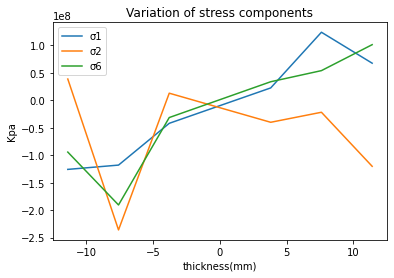

No handles with labels found to put in legend.


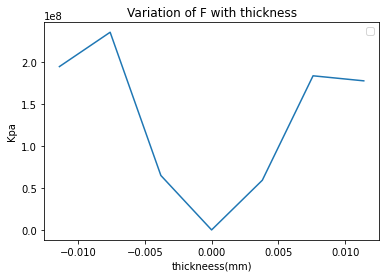

In [279]:
Stress().Tsai_Hill([-17, -115, -17, 83, -15, 83])


Model 2, based on the symmetry

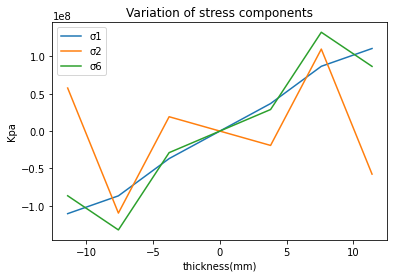

No handles with labels found to put in legend.


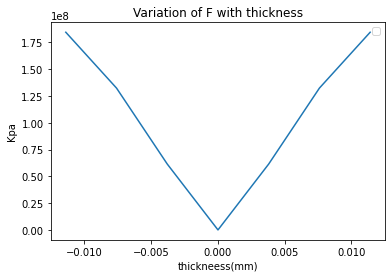

In [280]:

Stress().Tsai_Hill([-17, -115, -17, -17, -115, -17])
